# Import des librairies et initialisation de RayLib

In [1]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.policy.policy import PolicySpec
from minigrid.wrappers import ImgObsWrapper
# from multigrid.rllib import RLlibWrapper
from multi_agents_envs.new_multi_agent_env import NewMultiAgentGridWorldEnv
from multi_agents_envs.my_multi_agent_env import MultiAgentGridWorldEnv

import multigrid.envs
from multigrid.base import MultiGridEnv
from ray.rllib.env import MultiAgentEnv
import gymnasium as gym
import ray
from ray.tune.registry import register_env
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from gymnasium.spaces import Box, Dict
import time



if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)


2024-12-15 21:06:28,552	INFO worker.py:1821 -- Started a local Ray instance.


# Single agents environments 

## Minigrid

**Minigrid** est une librairie qui met à disposition des environements de type gridword customisable et jolies, cependant les observations que retourne leur environement n'ont pas le format attendue par l'algo PPO, qui utilise comme Policy un réseaux de neurone et qui attend donc un vecteur plat (flattened) avec des valeurs floats. 

C'est pour ça qu'il a fallut créer un **CustomWrapper**, qui permet d'ajouter une couche à l'environment, convertissant les sorties au bon format (aplatie, float).

J'applique aussi un autre wrapper fournit par minigrid (**ImgObsWrapper**) qui permet de retirer une valeur "mission" des observations retournées. 

In [ ]:

import numpy as np

class CustomFlatObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Calculer la taille de l'observation aplatie
        flat_obs_dim = np.prod(env.observation_space.shape)
        # Modifier l'espace d'observation
        self.observation_space = gym.spaces.Box(
            low=float(env.observation_space.low.min()),  # Minimum des observations
            high=float(env.observation_space.high.max()),  # Maximum des observations
            shape=(flat_obs_dim,),  # Taille aplatie
            dtype=np.float32,
        )

    def observation(self, obs):
        # Transformer l'observation en un vecteur 1D de type float32
        return obs.flatten().astype(np.float32)


def env_creator(env_config, render_mode=None):
    env = gym.make("MiniGrid-Empty-8x8-v0", render_mode=render_mode)  # Créez l'environnement MiniGrid
    env = ImgObsWrapper(env)  # Retire la mission de l'observation.
    env = CustomFlatObsWrapper(env)  # Appliquez le wrapper pour des observations aplaties
    return env

# Étape 2 : Enregistrer l'environnement avec RLlib
register_env("MiniGrid-FlatObs-8x8-v0", env_creator)



2024-12-10 17:07:03,753	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\algorithms\algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDep

(SingleAgentEnvRunner pid=12720) 2024-12-10 17:07:12,581	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


Iter: 0, Mean Reward: 0.0
Iter: 1, Mean Reward: 0.10188802083333331
Iter: 2, Mean Reward: 0.13013822115384616
Iter: 3, Mean Reward: 0.19714062499999996
Iter: 4, Mean Reward: 0.2980823863636364
Iter: 5, Mean Reward: 0.3544175091911764
Iter: 6, Mean Reward: 0.44750781250000005
Iter: 7, Mean Reward: 0.6337890625000001
Iter: 8, Mean Reward: 0.76016015625
Iter: 9, Mean Reward: 0.7655039062499998
Iter: 10, Mean Reward: 0.8218164062500002
Iter: 11, Mean Reward: 0.8813828125000001
Iter: 12, Mean Reward: 0.8988203124999998
Iter: 13, Mean Reward: 0.9141484374999999
Iter: 14, Mean Reward: 0.9247304687500001
Iter: 15, Mean Reward: 0.9289843750000002
Iter: 16, Mean Reward: 0.9329570312499998
Iter: 17, Mean Reward: 0.9357343750000001
Iter: 18, Mean Reward: 0.938828125
Iter: 19, Mean Reward: 0.9401640625000001
Iter: 20, Mean Reward: 0.9391796874999998
Iter: 21, Mean Reward: 0.94181640625
Iter: 22, Mean Reward: 0.9439609375000001
Iter: 23, Mean Reward: 0.9473359375000004
Iter: 24, Mean Reward: 0.94923

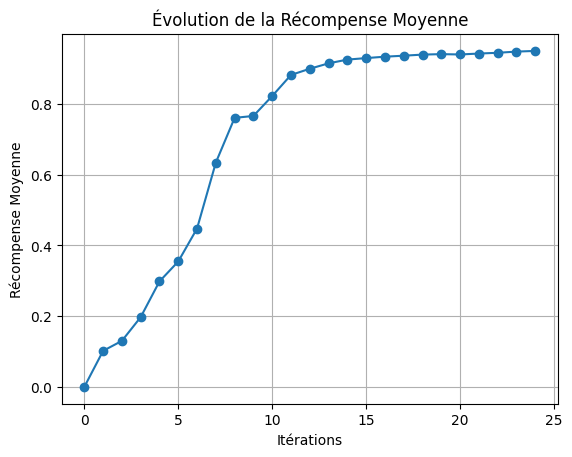

In [3]:


config = (
    PPOConfig()
    .environment(env="MiniGrid-FlatObs-8x8-v0")
    .training(train_batch_size=600)
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .framework("torch")

)

mean_returns = []
algo = config.build()
for i in range(25):
    result = algo.train()
    # Vérifiez les clés disponibles dans result si 'episode_reward_mean' n'y figure pas.
    mean_return = result["env_runners"]["agent_episode_returns_mean"]["default_agent"]
    mean_returns.append(mean_return)
    
    print(f"Iter: {i}, Mean Reward: {mean_return}")

# Tracer les résultats
plt.plot(range(len(mean_returns)), mean_returns, marker="o")
plt.xlabel("Itérations")
plt.ylabel("Récompense Moyenne")
plt.title("Évolution de la Récompense Moyenne")
plt.grid()
plt.show()

In [ ]:

# Créez une instance de l'environnement
test_env = env_creator({}, render_mode="rgb_array")  # Utilisez "rgb_array" pour le rendu vidéo

# Ajoutez les wrappers
video_trigger = lambda episode_id: episode_id % 1 == 0  # Enregistrer une vidéo pour chaque épisode
test_env = RecordVideo(test_env, video_folder="videos/", episode_trigger=video_trigger)  # Vidéo par épisode
test_env = RecordEpisodeStatistics(test_env)  # Enregistre les statistiques

rl_module = algo.get_module("default_policy")

episode_return = 0
terminated = truncated = False

# Réinitialisation de l'environnement
obs, info = test_env.reset()

while not terminated and not truncated:
    # Compute the next action from a batch (B=1) of observations
    torch_obs_batch = torch.from_numpy(np.array([obs]))
    action_logits = rl_module.forward_inference({"obs": torch_obs_batch})[
        "action_dist_inputs"
    ]
    # The default RLModule used here produces action logits (from which
    # we'll have to sample an action or use the max-likelihood one).
    action = int(torch.argmax(action_logits[0]).numpy())
    obs, reward, terminated, truncated, info = test_env.step(action)
    episode_return += reward
    print(reward, action, terminated, truncated)

    # Optionnel : Afficher les statistiques de l'épisode
    if "episode" in info.keys():
        print(f"Episode stats: {info['episode']}")

test_env.close()

print(f"Reached episode return of {episode_return}.")


0 2 False False
0 2 False False
0 2 False False
0 2 False False
0 2 False False
0 1 False False
0 2 False False
0 2 False False
0 2 False False
0 2 False False
0.961328125 2 True False
Episode stats: {'r': 0.961328125, 'l': 11, 't': 0.031123}
Reached episode return of 0.961328125.


In [22]:
test_env.close()


## My environment

Un exemple d'entrainement et de test d'agents sur un environement **gridword single agent basique** (le joueur doit atteindre la cible). Cet exemple permet de comprendre comment :
* **créer un environnement** avec RLlib
* **utiliser** cet environnement
* **initialiser** un agent 
* **entrainer** un agent sur cet environnement
* **Tester** l'agent entrainer
* **Visualiser** les résultats


### 1. Enrgistrer l'environnement

Une fois que l'environnement a été créer (classe séparée), il faut **l'enrigistrer dans le répertoire RLlib**, pour qu'il soit accessible facilement par les agents (qu'on initialisera plus tard) à l'aide d'un **identifiant (string)**

In [ ]:
from single_agent_envs.my_single_agent_env import GridWorldEnv

def env_creator(env_config):
    return GridWorldEnv(env_config)

register_env("GridWorldEnv", env_creator)

### 2. Initialisation de l'agent 

Tous les agents appartiennent à la classe algorithme, qui va contenir plusieurs modules :

* **RLModule** : Contient la politique (souvent un réseau de neurones), avec les fonctions pour prendre une action en fonction de l'observation. C'est ici que la logique d'inférence et d'apprentissage des actions est définie.
* **Policy** : Définit les règles ou stratégies utilisées par l'agent pour prendre des décisions. Cela inclut le modèle, les distributions d'actions (comme action_dist_inputs) et les méthodes pour l'entraînement et l'évaluation de la politique.
* **Trainer** : Responsable de l'entraînement des politiques. Il utilise l'algorithme de RL spécifié (par exemple PPO, DQN) pour mettre à jour les paramètres des RLModules.
* **RolloutWorker** (parfois appelé env_runer): une duplication de l'agent, qui va servir à collecter les données (transitions) par batch de taille fixe, les transmettre à l'agent principale, qui lui les utilisera pour mettre à jour les poids du modèle.
* **AlgorithmConfig** : En gros les paramètres de l'algorithme (nombre d'agents, type d'algorithme (PO, DQN..), paramètres du modèle, configuration de l'environnement, etc.).


In [ ]:
# Ici par exemple on créer une configuration de l'algorithme PPO avec des paramètres spécifiques
config = (
    PPOConfig()  # Utilisation de l'algorithme PPO 
    .environment(env="GridWorldEnv", env_config={"size": 16, "max_steps": 200})  # On spécifie l'environnement à utiliser (celui enregistré auparavant)
    .training(train_batch_size_per_learner=400)  
    .api_stack(  
        enable_rl_module_and_learner=True, 
        enable_env_runner_and_connector_v2=True,  
    )
    .framework("torch")  # Utilisation de PyTorch comme backend pour le modèle
)

# Initialisation de l'algorithme PPO à partir de la configuration
algo = config.build()



### 3. Boucle d'entrainement

In [3]:

mean_returns = []


for i in range(20):
    result = algo.train()  # Entraîner l'algorithme sur une itération

    # Extraction de la récompense moyenne pour l'agent "default_agent"
    mean_return = result["env_runners"]["agent_episode_returns_mean"]["default_agent"]
    mean_returns.append(mean_return)  

    print(f"Iter: {i}, Mean Reward: {mean_return}")

plt.plot(range(len(mean_returns)), mean_returns, marker="o")
plt.xlabel("Itérations")
plt.ylabel("Récompense Moyenne")
plt.title("Évolution de la Récompense Moyenne")
plt.grid()
plt.show()


2024-12-10 16:26:29,301	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\algorithms\algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDep

KeyboardInterrupt: 

### 4. Tester l'agent entrainer 

Il faut : 
* **Initialiser un nouvel environnement** pour tester l'agent entrainé dessus 
* **Récupérer la policy** de l'agent entrainé pour pouvoir effectuer des actions
* **répéter** jusqu'à ce que l'épisode soit terminé

In [10]:
import torch
import numpy as np

# Initialisation de l'environnement d'évaluation
eval_env = GridWorldEnv({"size": 16})

# On récupère la politique directement du RLModule
rl_module = algo.get_module("default_policy")

# Variables pour suivre l'épisode
episode_return = 0
terminated = truncated = False
obs, info = eval_env.reset()

# Boucle d'évaluation : exécute l'agent dans l'environnement jusqu'à la fin de l'épisode
while not terminated and not truncated:
    # Calcul de l'action à partir de l'observation (via le module RL)
    torch_obs_batch = torch.from_numpy(np.array([obs]))
    action_logits = rl_module.forward_inference({"obs": torch_obs_batch})["action_dist_inputs"]
    action = int(torch.argmax(action_logits[0]).numpy())  # Action maximale (greedy)

    # Exécution de l'action dans l'environnement
    obs, reward, terminated, truncated, info = eval_env.step(action)
    episode_return += reward  # Mise à jour du retour cumulé
    print(reward, action, terminated, truncated)  # Affichage des informations à chaque étape

# Affichage du retour total atteint dans l'épisode
print(f"Reached episode return of {episode_return}.")


-1 0 False False
-1 0 False False
-1 0 False False
-1 0 False False
-1 0 False False
-1 0 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 1 False False
-1 1 False False
-1 1 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 0 False False
-1 1 False False
-1 0 False False
50 1 True False
Reached episode return of 21.


# Multi-agents environments 

## My Multi Agent Env

In [2]:
def policy_mapping_fn(agent_id, episode=None):
    """
    Maps agent_id to a policy.
    """
    return agent_id  # Retourne le même ID que la politique


In [3]:
#FIRST MARL WORKING BASIC EVIRONMENT

# from multi_agents_envs.my_multi_agent_env import MultiAgentGridWorldEnv

# def multi_agent_env_creator(env_config):
#     return MultiAgentGridWorldEnv(env_config)

# register_env("MultiAgentGridWorldEnv", multi_agent_env_creator)

In [4]:

def multi_agent_env_creator(env_config):
    return NewMultiAgentGridWorldEnv(env_config)

register_env("MultiAgentGridWorldEnv", multi_agent_env_creator)

In [21]:
import torch
import numpy as np
import time

def evaluate_algorithm(algo, env_config, render_mode="human", record_video=False, video_folder="videos_multi_agent/"):
    """
    Evaluate an RLlib algorithm on a single episode.

    Args:
        algo: Trained RLlib algorithm instance.
        env_config (dict): Configuration for the evaluation environment.
        render_mode (str): Rendering mode ("human" or "rgb_array").
        record_video (bool): If True, records a video of the evaluation episode.
        video_folder (str): Directory to save recorded videos.

    Returns:
        Tuple: Total rewards for agent_1 and agent_2.
    """
    from gymnasium.wrappers import RecordVideo

    # Initialize the evaluation environment
    eval_env = NewMultiAgentGridWorldEnv(env_config={"size": env_config["size"], 
                                                     "max_steps": env_config["max_steps"], 
                                                     "render_mode": render_mode})

    # Optional: Wrap the environment to record a video
    if record_video:
        video_trigger = lambda episode_id: episode_id == 0  # Record only the first episode
        eval_env = RecordVideo(eval_env, video_folder=video_folder, episode_trigger=video_trigger)

    # Access RLModules for the agents
    rl_module_1 = algo.get_module("agent_1")
    rl_module_2 = algo.get_module("agent_2")

    def get_action(rl_module, observation):
        """Compute action for a given RL module and observation."""
        torch_obs_batch = torch.from_numpy(np.array([observation]))
        action_logits = rl_module.forward_inference({"obs": torch_obs_batch})["action_dist_inputs"]
        action = int(torch.argmax(action_logits[0]).numpy())
        return action

    # Episode tracking
    episode_return_1 = 0
    episode_return_2 = 0
    terminated = {"__all__": False}
    truncated = {"__all__": False}

    # Reset the environment
    obs, info = eval_env.reset()

    # Evaluation loop
    while not terminated["__all__"] and not truncated["__all__"]:
        actions = {}
        if "agent_1" in obs:
            actions["agent_1"] = get_action(rl_module_1, obs["agent_1"])
        if "agent_2" in obs:
            actions["agent_2"] = get_action(rl_module_2, obs["agent_2"])

        obs, rewards, terminated, truncated, info = eval_env.step(actions)

        # Update episode returns
        episode_return_1 += rewards.get("agent_1", 0)
        episode_return_2 += rewards.get("agent_2", 0)

        # Print step information
        # print(f"Step Info: Agent 1 Reward = {rewards.get('agent_1', 0)}, Agent 2 Reward = {rewards.get('agent_2', 0)}")

        time.sleep(0.01)  # Optional delay for better rendering visualization

    # Close the environment
    eval_env.close()

    # Final episode returns
    print(f"Final Episode Return - Agent 1: {episode_return_1}, Agent 2: {episode_return_2}")

    return episode_return_1, episode_return_2


In [25]:
env_config = {
    "size": 5,
    "max_steps": 800,
    "render_mode": "human"  # Set render mode to "human" for visualization
}

batch_size = 4000   

# Configurer RLlib pour un environnement multi-agent
config = (
    PPOConfig()
    .environment(env="MultiAgentGridWorldEnv", env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps")})
    .training(train_batch_size_per_learner=batch_size)
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .framework("torch")
    .multi_agent(
        policies={
            "agent_1": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
            "agent_2": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
        },
        policy_mapping_fn=policy_mapping_fn,
    )
)

algo = config.build()


2024-12-15 21:19:21,355	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\algorithms\algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDep

In [26]:


env = NewMultiAgentGridWorldEnv(env_config)

# Reset the environment
observations, _ = env.reset()

# Perform a few steps and render the environment
for _ in range(10):  # Perform 10 steps for testing
    # Random actions for each agent
    actions = {agent_id: env.action_space[agent_id].sample() for agent_id in env.get_agent_ids()}

    # Step the environment
    observations, rewards, terminated, truncated, infos = env.step(actions)

    # Sleep for a short duration to visualize the rendering
    time.sleep(0.5)

    # Check if the episode is done
    if terminated["__all__"] or truncated["__all__"]:
        break

# Close the environment
env.close()


Iter: 0, Mean Reward agent 1: 171.36046511627907
Iter: 0, Mean Reward agent 2: 164.75581395348837
Iter: 1, Mean Reward agent 1: 173.52
Iter: 1, Mean Reward agent 2: 176.95
Iter: 2, Mean Reward agent 1: 191.54
Iter: 2, Mean Reward agent 2: 192.28
Iter: 3, Mean Reward agent 1: 202.53
Iter: 3, Mean Reward agent 2: 193.7
Iter: 4, Mean Reward agent 1: 229.43
Iter: 4, Mean Reward agent 2: 209.64
Iter: 5, Mean Reward agent 1: 243.58
Iter: 5, Mean Reward agent 2: 217.59
Iter: 6, Mean Reward agent 1: 262.16
Iter: 6, Mean Reward agent 2: 233.02
Iter: 7, Mean Reward agent 1: 278.91
Iter: 7, Mean Reward agent 2: 245.52
Iter: 8, Mean Reward agent 1: 269.31
Iter: 8, Mean Reward agent 2: 243.85
Iter: 9, Mean Reward agent 1: 280.04
Iter: 9, Mean Reward agent 2: 251.98
Iter: 10, Mean Reward agent 1: 288.58
Iter: 10, Mean Reward agent 2: 266.69
Iter: 11, Mean Reward agent 1: 291.36
Iter: 11, Mean Reward agent 2: 279.71
Iter: 12, Mean Reward agent 1: 284.29
Iter: 12, Mean Reward agent 2: 274.12
Iter: 13,

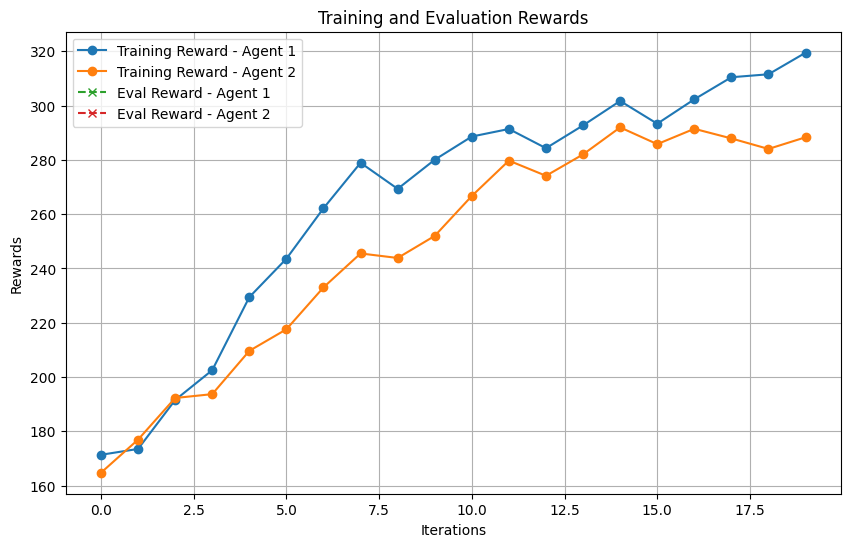

In [28]:
# Initialize lists for tracking mean rewards and evaluation returns
mean_returns_1 = []
mean_returns_2 = []
eval_returns_1 = []
eval_returns_2 = []

# Training loop
for i in range(20):
    result = algo.train()

    # Get training rewards
    mean_return_agent_1 = result["env_runners"]["agent_episode_returns_mean"].get("agent_1", 0)
    mean_return_agent_2 = result["env_runners"]["agent_episode_returns_mean"].get("agent_2", 0)

    mean_returns_1.append(mean_return_agent_1)
    mean_returns_2.append(mean_return_agent_2)

    print(f"Iter: {i}, Mean Reward agent 1: {mean_return_agent_1}")
    print(f"Iter: {i}, Mean Reward agent 2: {mean_return_agent_2}")

    # Evaluate the algorithm on one episode
    # eval_return_1, eval_return_2 = evaluate_algorithm(algo, env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps")})
    # eval_returns_1.append(eval_return_1)
    # eval_returns_2.append(eval_return_2)

# Plot training and evaluation rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_returns_1)), mean_returns_1, marker="o", label="Training Reward - Agent 1")
plt.plot(range(len(mean_returns_2)), mean_returns_2, marker="o", label="Training Reward - Agent 2")
plt.plot(range(len(eval_returns_1)), eval_returns_1, marker="x", linestyle="--", label="Eval Reward - Agent 1")
plt.plot(range(len(eval_returns_2)), eval_returns_2, marker="x", linestyle="--", label="Eval Reward - Agent 2")
plt.xlabel("Iterations")
plt.ylabel("Rewards")
plt.title("Training and Evaluation Rewards")
plt.legend()
plt.grid()
plt.show()


In [29]:
evaluate_algorithm(algo, env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps")}, render_mode= "human", record_video=False, video_folder="videos_multi_agent/")


Final Episode Return - Agent 1: 327, Agent 2: 296


(327, 296)

In [9]:
eval_env.close()

In [12]:
import torch
import numpy as np 

def get_action(rl_module, observation):
    """
    Compute the action for a given agent based on the observation.

    Args:
        rl_module: The RLModule for the agent.
        observation: The current observation for the agent.

    Returns:
        int: The action chosen by the agent.
    """
    torch_obs_batch = torch.from_numpy(np.array([observation]))
    action_logits = rl_module.forward_inference({"obs": torch_obs_batch})[
        "action_dist_inputs"
    ]
    action = int(torch.argmax(action_logits[0]).numpy())
    return action

# Initialize the evaluation environment
eval_env = NewMultiAgentGridWorldEnv(env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps"), "render_mode":"rgb_array"})

# Ajoutez les wrappers
video_trigger = lambda episode_id: episode_id % 1 == 0  # Enregistrer une vidéo pour chaque épisode
eval_env = RecordVideo(eval_env, video_folder="videos_multi_agent/", episode_trigger=video_trigger)  # Vidéo par épisode

# Access RLModules for the agents
rl_module_1 = algo.get_module("agent_1")
rl_module_2 = algo.get_module("agent_2")

episode_return_1 = 0
episode_return_2 = 0
terminated = {"__all__": False}
truncated = {"__all__": False}

# Reset the environment
obs, info = eval_env.reset()

while not terminated["__all__"] and not truncated["__all__"]:
    # Compute actions only for active agents
    actions = {}
    if "agent_1" in obs:
        action_1 = get_action(rl_module_1, obs["agent_1"])
        actions["agent_1"] = action_1
    if "agent_2" in obs:
        action_2 = get_action(rl_module_2, obs["agent_2"])
        actions["agent_2"] = action_2

    # Perform a step in the environment
    obs, rewards, terminated, truncated, info = eval_env.step(actions)

    # Update episode returns for active agents
    if "agent_1" in rewards:
        episode_return_1 += rewards["agent_1"]
    if "agent_2" in rewards:
        episode_return_2 += rewards["agent_2"]

    # Print the step information
    if "agent_1" in actions:
        print(f"Agent 1 - Reward: {rewards.get('agent_1', 0)}, Action: {actions['agent_1']}")
    if "agent_2" in actions:
        print(f"Agent 2 - Reward: {rewards.get('agent_2', 0)}, Action: {actions['agent_2']}")
    
    time.sleep(0.5)

# Print the final episode returns
print(f"Agent 1 reached an episode return of {episode_return_1}.")
print(f"Agent 2 reached an episode return of {episode_return_2}.")

eval_env.close()

c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\idris\Desktop\AaCours\Canada\Double_Diplome\automne_2024\Reinforcement Learning\TPs\Projet\videos_multi_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Agent 1 - Reward: 10, Action: 0
Agent 2 - Reward: 10, Action: 3
Agent 1 - Reward: 10, Action: 0
Agent 2 - Reward: 10, Action: 3
Agent 1 - Reward: 10, Action: 0
Agent 2 - Reward: 10, Action: 3
Agent 1 - Reward: 10, Action: 1
Agent 2 - Reward: -1, Action: 0
Agent 1 - Reward: 10, Action: 1
Agent 2 - Reward: -1, Action: 0
Agent 1 - Reward: 10, Action: 1
Agent 2 - Reward: 10, Action: 1
Agent 1 - Reward: 10, Action: 2
Agent 2 - Reward: 10, Action: 1
Agent 1 - Reward: 10, Action: 2
Agent 2 - Reward: -1, Action: 0
Agent 1 - Reward: -1, Action: 0
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 2
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 0
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 2
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 0
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 2
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 0
Agent 2 - Reward: -1, Action: 1
Agent 1 - Reward: -1, Action: 2
Agent 2 

KeyboardInterrupt: 

In [12]:
eval_env.recorded_frames

[]

## MultiGrid 

In [9]:


class RLlibWrapper(gymnasium.Wrapper, MultiAgentEnv):
    """
    Wrapper for a ``MultiGridEnv`` environment that implements the
    RLlib ``MultiAgentEnv`` interface.
    """

    def __init__(self, env: MultiGridEnv):
        self._obs_space_in_preferred_format = True
        self._action_space_in_preferred_format = True
        print("base agents: ", env.observation_space)
        gymnasium.Wrapper.__init__(self, env)
        MultiAgentEnv.__init__(self)
        self.observation_spaces = self.env.observation_space
        self.action_spaces = self.env.action_space
        print("we are in the rllib wrapper")
        print('rllib agents: ', self.agents)

    def get_agent_ids(self):
        
        return {agent.index for agent in self.agents}

    def step(self, *args, **kwargs):
        obs, rewards, terminations, truncations, infos = super().step(*args, **kwargs)
        terminations['__all__'] = all(terminations.values())
        truncations['__all__'] = all(truncations.values())
        return obs, rewards, terminations, truncations, infos
    
    




In [ ]:


class CustomMultiGridObsWrapper(gymnasium.core.ObservationWrapper):
    """
    Wrapper pour aplatir les observations des agents et supprimer les missions.
    Fonctionne pour les environnements MultiGrid avec des observations sous forme de dictionnaires.
    """

    def __init__(self, env):
        super().__init__(env)
        # Créer un nouvel espace d'observation sans la mission et avec des observations aplaties
        self.observation_space = Dict({
            agent_id: Box(
                low=0,
                high=255,  # Plage de valeurs pour les pixels d'image
                shape=(np.prod(space["image"].shape) + 1,),  # Inclut direction aplatie
                dtype=np.float32
            )
            for agent_id, space in env.observation_space.spaces.items()
        })

    def observation(self, obs):
        """
        Transforme les observations des agents.
        - Aplatie l'image.
        - Ajoute la direction comme une valeur scalaire.
        - Supprime la mission.
        """
        transformed_obs = {}
        for agent_id, agent_obs in obs.items():
            # Aplatir l'image et ajouter la direction
            flat_image = agent_obs["image"].flatten().astype(np.float32)
            direction = np.array([agent_obs["direction"]], dtype=np.float32)
            transformed_obs[agent_id] = np.concatenate([flat_image, direction])
        print(f"Transformed observation for all agents: {transformed_obs[0].shape}")

        return transformed_obs



In [11]:

def multi_grid_env_creator(config):
    
    render_mode = config.get("render_mode", "human")  # Extraire render_mode du dictionnaire config
    agents = config.get("agents", 2)  # Nombre d'agents par défaut
    
    base_env = gymnasium.make("MultiGrid-Empty-6x6-v0", agents = agents, render_mode=render_mode)
    custom_wrapped_env = CustomMultiGridObsWrapper(base_env)
    rllib_wrapped_env = RLlibWrapper(custom_wrapped_env)

    return rllib_wrapped_env

# Étape 2 : Enregistrer l'environnement avec RLlib
register_env("Multigrid-custom-6x6-v0", multi_grid_env_creator)



In [12]:

env = multi_grid_env_creator({"agents": 2})  # Créez l'environnement
obs, info = env.reset()  # Réinitialisez l'environnement
env.close()
env.render_mode


we are here:  2
base agents:  Dict(0: Box(0.0, 255.0, (148,), float32), 1: Box(0.0, 255.0, (148,), float32))
we are in the rllib wrapper
rllib agents:  []
Transformed observation for all agents: (148,)


'human'

In [2]:


class MultiGridRLlibWrapper(MultiAgentEnv):
    """
    Wrapper for a MultiGridEnv environment that implements the RLlib MultiAgentEnv interface
    and flattens observations for easier processing.
    """

    def __init__(self, env: MultiGridEnv):
        # Initialize as MultiAgentEnv first
        MultiAgentEnv.__init__(self)

        # Store the original environment
        self.env = env

        # Create observation spaces
        self.observation_spaces = Dict({
            agent_id: Box(
                low=0,
                high=255,
                shape=(np.prod(space["image"].shape) + 1,),
                dtype=np.float32
            )
            for agent_id, space in env.observation_space.spaces.items()
        })

        # Create action spaces
        self.action_spaces = env.action_space

        # Multiagent-specific attributes
        self._agent_ids = {agent.index for agent in env.agents}
        
        print("MultiGrid RLlib Wrapper Initialized")
        print("Observation Spaces:", self.observation_spaces)
        print("Action Spaces:", self.action_spaces)

    def get_agent_ids(self):
        """
        Return a set of all agent IDs in the environment.
        """
        return self._agent_ids

    def step(self, action_dict):
        """
        Custom step method that handles multi-agent actions and observations.
        """
        # Convert action_dict to a format the environment understands
        actions = [action_dict.get(agent_index, None) for agent_index in self._agent_ids]
        
        # Perform environment step
        obs, rewards, terminations, truncations, infos = self.env.step(actions)
        
        # Flatten observations
        flattened_obs = {}
        for agent_id, agent_obs in obs.items():
            flat_image = agent_obs["image"].flatten().astype(np.float32)
            direction = np.array([agent_obs["direction"]], dtype=np.float32)
            flattened_obs[agent_id] = np.concatenate([flat_image, direction])
        
        # Add special '__all__' termination and truncation keys
        terminations['__all__'] = all(terminations.values())
        truncations['__all__'] = all(truncations.values())
        
        return flattened_obs, rewards, terminations, truncations, infos

    def reset(self, seed=None, options=None):
        """
        Reset the environment and return initial observations.
        """
        obs, info = self.env.reset(seed=seed, options=options)
        
        # Flatten initial observations
        flattened_obs = {}
        for agent_id, agent_obs in obs.items():
            flat_image = agent_obs["image"].flatten().astype(np.float32)
            direction = np.array([agent_obs["direction"]], dtype=np.float32)
            flattened_obs[agent_id] = np.concatenate([flat_image, direction])
        
        return flattened_obs, info

    def render(self):
        """
        Render the environment.
        """
        return self.env.render()

In [3]:
def env_creator(env_config):
    # Create the base MultiGrid environment
    env = multigrid.envs.empty.EmptyEnv(**env_config)
    
    # Wrap it with the MultiAgentEnv wrapper
    multi_agent_env = MultiGridRLlibWrapper(env)
    
    return multi_agent_env


In [4]:
def new_env_creator(env_config):
    """
    Create a new MultiGridRLlibWrapper environment.
    """
    render_mode = env_config.get("render_mode", "human")
    agents = env_config.get("agents", 2)
    
    base_env = gymnasium.make("MultiGrid-Empty-6x6-v0", agents=agents, render_mode=render_mode)
    rllib_wrapped_env = MultiGridRLlibWrapper(base_env)
    
    return rllib_wrapped_env

register_env("Multigrid-custom-6x6-v0", env_creator)


In [5]:
def policy_mapping_fn_multigrid(agent_id, episode=None):
    """
    Maps agent_id to a policy.
    """
    if agent_id == 0:
        return "agent_1"
    if agent_id == 1:
        return "agent_2"
    else:
        raise ValueError(f"Unknown agent_id: {agent_id}")


In [6]:
env = env_creator({"agents": 2}) 
env.reset()
env.agents

we are here:  2
MultiGrid RLlib Wrapper Initialized
Observation Spaces: Dict(0: Box(0.0, 255.0, (148,), float32), 1: Box(0.0, 255.0, (148,), float32))
Action Spaces: Dict(0: Discrete(7), 1: Discrete(7))


[]

In [7]:
config = (
    PPOConfig()
    .environment(env="Multigrid-custom-6x6-v0")
    .training(train_batch_size_per_learner=600)
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .framework("torch")
    .multi_agent(
        policies={
            "agent_1": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
            "agent_2": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
        },
        policy_mapping_fn=policy_mapping_fn_multigrid,
    )
)

algo = config.build()


2024-12-11 20:21:02,318	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\algorithms\algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could 

(MultiAgentEnvRunner pid=6868) we are here:  1
(MultiAgentEnvRunner pid=6868) MultiGrid RLlib Wrapper Initialized
(MultiAgentEnvRunner pid=6868) Observation Spaces: Dict(0: Box(0.0, 255.0, (148,), float32))
(MultiAgentEnvRunner pid=6868) Action Spaces: Dict(0: Discrete(7))


(MultiAgentEnvRunner pid=6868) 2024-12-11 20:21:10,949	ERROR multi_agent_env_runner.py:858 -- The element returned by reset() has agent_ids that are not the names of the agents in the env. 
(MultiAgentEnvRunner pid=6868) AgentIDs in this MultiAgentDict: [0]
(MultiAgentEnvRunner pid=6868) AgentIDs in this env: []. You likely need to add the attribute `agents` to your env, which is a list containing the IDs of agents currently in your env/episode, as well as, `possible_agents`, which is a list of all possible agents that could ever show up in your env.
(MultiAgentEnvRunner pid=6868) Traceback (most recent call last):
(MultiAgentEnvRunner pid=6868)   File "c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\env\multi_agent_env_runner.py", line 856, in make_env
(MultiAgentEnvRunner pid=6868)     check_multiagent_environments(self.env.unwrapped)
(MultiAgentEnvRunner pid=6868)   File "c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\

we are here:  1
MultiGrid RLlib Wrapper Initialized
Observation Spaces: Dict(0: Box(0.0, 255.0, (148,), float32))
Action Spaces: Dict(0: Discrete(7))


StopIteration: 

In [55]:
env.close()